In [1]:
import numpy as np
import pandas as pd
import json
import math
from pathlib import Path

# โมเดล
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Keras RNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [2]:
# โหลดไฟล์ Excel (sheet2)
df = pd.read_excel("/content/new data.xlsx", sheet_name="Sheet2")
df

,รหัสสถานี-สถานี-จังหวัด,Date,Showalter,Lifted,SWEAT,K,Cross,Vertical,TT Totals,CAPE,CIN,BRN,LCL Temp,LCL P,LCL P.1,MML θ,MML q,Thickness,PWAT,dBZ
0,327501-เชียงใหม่ จ.เชียงใหม่,2018-02-01,13.29,16.28,244.92,-27.1,5.7,19.7,25.4,0,0,0,276.14,783.2,314.16,296.13,6.16,5749,12.64,0.0
1,327501-เชียงใหม่ จ.เชียงใหม่,2018-02-02,10.78,11.77,127.18,-22.1,10.3,19.3,29.6,0,0,0,281.45,839.9,319.96,295.87,8.3,5746,16.33,0.0
2,327501-เชียงใหม่ จ.เชียงใหม่,2018-02-03,3.53,4.54,362.3,-14.3,19.3,19.7,39,15.68,-46.73,0.86,288.03,903.9,331.01,296.49,11.91,5729,25.68,0.0
3,327501-เชียงใหม่ จ.เชียงใหม่,2018-02-04,4.66,5.24,200.4,-18,18.8,19.3,38.1,0,-50.25,0,285.99,879.04,327.88,296.74,10.71,5734,22.45,0.0
4,327501-เชียงใหม่ จ.เชียงใหม่,2018-02-05,7.09,8.06,170.99,-0.7,15.3,18.3,33.6,0,0,0,285.51,868.8,327.84,297.24,10.51,5733,22.85,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,327501-เชียงใหม่ จ.เชียงใหม่,2021-02-08,-4.55,-5.04,352.01,40,25.5,30.3,55.8,318.19,-95.93,3.38,289.19,896,336.27,298.43,13,5695,38.11,36.5
368,327501-เชียงใหม่ จ.เชียงใหม่,2021-02-09,0.55,2.57,162.58,2,23,23.7,46.7,6.52,-108.75,0.17,284.68,877.22,324.07,295.55,9.87,5636,22.42,31.5
369,327501-เชียงใหม่ จ.เชียงใหม่,2021-02-10,8.44,9.02,142.21,-4.7,13.7,19.7,33.4,0,0,0,284.29,880.49,322.46,294.84,9.55,5677,19.51,44.0
370,327501-เชียงใหม่ จ.เชียงใหม่,2021-02-11,10.57,10.84,103.01,-18.9,10.1,20.1,30.2,0,0,0,283.37,871.98,320.92,294.7,9.08,5721,18.15,39.0


In [19]:
df = df.replace('-', np.nan)
df = df.apply(pd.to_numeric, errors="ignore")

# แปลง Date
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day

# แยก รหัสสถานี-สถานี-จังหวัด ออกเป็นคอลัมน์ใหม่
df_split = df.copy()
df_split[["รหัสสถานี", "สถานีจังหวัด"]] = df_split["รหัสสถานี-สถานี-จังหวัด"].str.split("-", n=1, expand=True)
df_split[["อำเภอ", "จังหวัด"]] = df_split["สถานีจังหวัด"].str.extract(r'(.+)\s+จ\.(.+)')
df_split["อำเภอ"] = df_split["อำเภอ"].str.strip().replace("เชียงใหม่", "เมือง")  # ตัวอย่างแก้ชื่อ
df_split["จังหวัด"] = df_split["จังหวัด"].str.strip()

# ลบ space หน้าหลังชื่อคอลัมน์
df.columns = df.columns.str.strip()
# y = dBZ
y = df_split["dBZ"].astype(float)
# X = ใช้ df_split หลังจากแยกแล้ว
X = df_split.drop(columns=["dBZ", "Date", "รหัสสถานี-สถานี-จังหวัด","รหัสสถานี", "สถานีจังหวัด"], errors="ignore")

/tmp/ipython-input-3276370539.py:2: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors="ignore")


In [4]:
print("ยังมีเครื่องหมายขีดอยู่มั้ย:", (df.astype(str) == "-").sum().sum())

ยังมีเครื่องหมายขีดอยู่มั้ย: 0


In [20]:
print(df_split.columns.tolist())

['รหัสสถานี-สถานี-จังหวัด', 'Date', 'Showalter', 'Lifted', 'SWEAT', 'K', 'Cross', 'Vertical', 'TT Totals', 'CAPE', 'CIN', 'BRN', 'LCL Temp', 'LCL P', 'LCL P.1', 'MML θ', 'MML q', 'Thickness', 'PWAT', 'dBZ', 'Year', 'Month', 'Day', 'รหัสสถานี', 'สถานีจังหวัด', 'อำเภอ', 'จังหวัด']


In [21]:
X

,Showalter,Lifted,SWEAT,K,Cross,Vertical,TT Totals,CAPE,CIN,BRN,...,LCL P.1,MML θ,MML q,Thickness,PWAT,Year,Month,Day,อำเภอ,จังหวัด
0,13.29,16.28,244.92,-27.1,5.7,19.7,25.4,0.00,0.00,0.00,...,314.16,296.13,6.16,5749.0,12.64,2018,2,1,เมือง,เชียงใหม่
1,10.78,11.77,127.18,-22.1,10.3,19.3,29.6,0.00,0.00,0.00,...,319.96,295.87,8.30,5746.0,16.33,2018,2,2,เมือง,เชียงใหม่
2,3.53,4.54,362.30,-14.3,19.3,19.7,39.0,15.68,-46.73,0.86,...,331.01,296.49,11.91,5729.0,25.68,2018,2,3,เมือง,เชียงใหม่
3,4.66,5.24,200.40,-18.0,18.8,19.3,38.1,0.00,-50.25,0.00,...,327.88,296.74,10.71,5734.0,22.45,2018,2,4,เมือง,เชียงใหม่
4,7.09,8.06,170.99,-0.7,15.3,18.3,33.6,0.00,0.00,0.00,...,327.84,297.24,10.51,5733.0,22.85,2018,2,5,เมือง,เชียงใหม่
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,-4.55,-5.04,352.01,40.0,25.5,30.3,55.8,318.19,-95.93,3.38,...,336.27,298.43,13.00,5695.0,38.11,2021,2,8,เมือง,เชียงใหม่
368,0.55,2.57,162.58,2.0,23.0,23.7,46.7,6.52,-108.75,0.17,...,324.07,295.55,9.87,5636.0,22.42,2021,2,9,เมือง,เชียงใหม่
369,8.44,9.02,142.21,-4.7,13.7,19.7,33.4,0.00,0.00,0.00,...,322.46,294.84,9.55,5677.0,19.51,2021,2,10,เมือง,เชียงใหม่
370,10.57,10.84,103.01,-18.9,10.1,20.1,30.2,0.00,0.00,0.00,...,320.92,294.70,9.08,5721.0,18.15,2021,2,11,เมือง,เชียงใหม่


In [44]:
# สมมติ df_split เป็น DataFrame ที่แยกจังหวัด/อำเภอ/รหัสสถานีแล้ว
# และ X, y เตรียมไว้แล้วตามก่อนหน้า

# --- mandatory features ที่บังคับให้เข้าโมเดล ---
mandatory_features = ["Year", "Month", "Day", "อำเภอ", "จังหวัด"]

# --- เลือกเฉพาะคอลัมน์ numeric เพื่อคำนวณ correlation ---
X_numeric = X.select_dtypes(include=[np.number]).copy()

# คำนวณ corr กับ y
corr = X_numeric.corrwith(y)

# กำหนด threshold
threshold = 0.3

# ฟีเจอร์ที่ผ่าน threshold
selected_corr_features = corr[abs(corr) >= threshold].index.tolist()

# fallback ถ้าไม่มีตัวที่ผ่าน
if len(selected_corr_features) == 0:
    selected_corr_features = corr.abs().sort_values(ascending=False).head(10).index.tolist()

# สร้าง final_features = union ระหว่าง selected_corr_features + mandatory_features
final_features = list(set(selected_corr_features).union(set(mandatory_features)))

# ถ้าชื่อคอลัมน์ mandatory อยู่ใน X
# ให้ตรวจว่าแต่ละ mandatory feature อยู่ใน X นี้หรือไม่
existing_final_features = [feat for feat in final_features if feat in X.columns]

print("✅ ฟีเจอร์ที่เลือกโดย correlation (numeric):", selected_corr_features)
print("📌 mandatory features:", mandatory_features)
print("🏁 ฟีเจอร์สุดท้ายที่จะใช้จริง:", existing_final_features)

# สร้าง X ใหม่ที่ใช้ final features
X_final = X[existing_final_features].copy()

✅ ฟีเจอร์ที่เลือกโดย correlation (numeric): ['Year', 'LCL Temp', 'SWEAT', 'LCL P.1', 'MML q', 'Cross', 'K', 'LCL P', 'Lifted', 'Showalter']
📌 mandatory features: ['Year', 'Month', 'Day', 'อำเภอ', 'จังหวัด']
🏁 ฟีเจอร์สุดท้ายที่จะใช้จริง: ['LCL P.1', 'Cross', 'Day', 'จังหวัด', 'Month', 'Showalter', 'K', 'LCL Temp', 'Year', 'SWEAT', 'LCL P', 'MML q', 'อำเภอ', 'Lifted']


In [45]:
import numpy as np

# 1) เลือกเฉพาะคอลัมน์ที่เป็น numeric
X_numeric = X.select_dtypes(include=[np.number])

# 2) คำนวณ correlation เฉพาะ numeric columns
corr = X_numeric.corrwith(y)

# 3) เลือกฟีเจอร์ตาม threshold
threshold = 0.3
selected_features = corr[abs(corr) >= threshold].index.tolist()

# fallback ถ้าไม่มีฟีเจอร์ผ่าน threshold
if len(selected_features) == 0:
    selected_features = corr.abs().sort_values(ascending=False).head(10).index.tolist()

# 4) รวมกับ mandatory features
mandatory_features = ["อำเภอ","จังหวัด","Year","Month","Day"]
final_features = list(set(selected_features).union(set(mandatory_features)))

# 5) แสดงผล
print("✅ ฟีเจอร์ที่ใช้จริง:", final_features)

print("\n=== Correlation ของฟีเจอร์ที่ใช้จริง (รวม mandatory) ===")
print(corr.reindex(final_features).sort_values(ascending=False))

✅ ฟีเจอร์ที่ใช้จริง: ['LCL P.1', 'Cross', 'Day', 'จังหวัด', 'Month', 'Showalter', 'K', 'LCL Temp', 'Year', 'SWEAT', 'LCL P', 'MML q', 'อำเภอ', 'Lifted']

=== Correlation ของฟีเจอร์ที่ใช้จริง (รวม mandatory) ===
Year         0.190006
LCL Temp     0.171716
SWEAT        0.170515
LCL P.1      0.169923
MML q        0.167635
Cross        0.161753
K            0.134563
LCL P        0.127117
Month        0.060412
Day         -0.022626
Showalter   -0.125767
Lifted      -0.126423
จังหวัด           NaN
อำเภอ             NaN
dtype: float64


In [46]:
# y = target
y = df_split["dBZ"].astype(float)

# X = ฟีเจอร์ที่เลือก (รวม mandatory)
X = df_split[final_features].copy()

In [27]:
X

,LCL P.1,Cross,Day,จังหวัด,Month,Showalter,K,LCL Temp,Year,SWEAT,LCL P,MML q,อำเภอ,Lifted
0,314.16,5.7,1,เชียงใหม่,2,13.29,-27.1,276.14,2018,244.92,783.20,6.16,เมือง,16.28
1,319.96,10.3,2,เชียงใหม่,2,10.78,-22.1,281.45,2018,127.18,839.90,8.30,เมือง,11.77
2,331.01,19.3,3,เชียงใหม่,2,3.53,-14.3,288.03,2018,362.30,903.90,11.91,เมือง,4.54
3,327.88,18.8,4,เชียงใหม่,2,4.66,-18.0,285.99,2018,200.40,879.04,10.71,เมือง,5.24
4,327.84,15.3,5,เชียงใหม่,2,7.09,-0.7,285.51,2018,170.99,868.80,10.51,เมือง,8.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,336.27,25.5,8,เชียงใหม่,2,-4.55,40.0,289.19,2021,352.01,896.00,13.00,เมือง,-5.04
368,324.07,23.0,9,เชียงใหม่,2,0.55,2.0,284.68,2021,162.58,877.22,9.87,เมือง,2.57
369,322.46,13.7,10,เชียงใหม่,2,8.44,-4.7,284.29,2021,142.21,880.49,9.55,เมือง,9.02
370,320.92,10.1,11,เชียงใหม่,2,10.57,-18.9,283.37,2021,103.01,871.98,9.08,เมือง,10.84


In [47]:
from sklearn.preprocessing import LabelEncoder

# สำเนา X
X_enc = X.copy()

# Encode จังหวัด
if "จังหวัด" in X_enc.columns:
    le_province = LabelEncoder()
    X_enc["จังหวัด"] = le_province.fit_transform(X_enc["จังหวัด"])

# Encode อำเภอ
if "อำเภอ" in X_enc.columns:
    le_district = LabelEncoder()
    X_enc["อำเภอ"] = le_district.fit_transform(X_enc["อำเภอ"])

# # Encode รหัสสถานี (ถ้าเป็น string)
# if "รหัสสถานี" in X_enc.columns and X_enc["รหัสสถานี"].dtype == "object":
#     le_station = LabelEncoder()
#     X_enc["รหัสสถานี"] = le_station.fit_transform(X_enc["รหัสสถานี"])

In [ ]:
print(X_enc.head())
print(X_enc.dtypes)

      K  LCL Temp  Lifted  Year  Showalter  MML q   PWAT  Month   LCL P  \
0 -27.1    276.14   16.28  2018      13.29   6.16  12.64      2  783.20   
1 -22.1    281.45   11.77  2018      10.78   8.30  16.33      2  839.90   
2 -14.3    288.03    4.54  2018       3.53  11.91  25.68      2  903.90   
3 -18.0    285.99    5.24  2018       4.66  10.71  22.45      2  879.04   
4  -0.7    285.51    8.06  2018       7.09  10.51  22.85      2  868.80   

   LCL P.1  Cross  อำเภอ  จังหวัด    CIN  Day   SWEAT  
0   314.16    5.7      0        0   0.00    1  244.92  
1   319.96   10.3      0        0   0.00    2  127.18  
2   331.01   19.3      0        0 -46.73    3  362.30  
3   327.88   18.8      0        0 -50.25    4  200.40  
4   327.84   15.3      0        0   0.00    5  170.99  
K            float64
LCL Temp     float64
Lifted       float64
Year           int32
Showalter    float64
MML q        float64
PWAT         float64
Month          int32
LCL P        float64
LCL P.1      float64
Cro

In [48]:
# province mapping
mapping_province = dict(zip(le_province.classes_, le_province.transform(le_province.classes_)))
print("📍 Mapping จังหวัด -> ตัวเลข")
print(mapping_province)

# district mapping
mapping_district = dict(zip(le_district.classes_, le_district.transform(le_district.classes_)))
print("\n📍 Mapping อำเภอ -> ตัวเลข")
print(mapping_district)

# station mapping (ถ้า encode)
if "รหัสสถานี" in X.columns and X["รหัสสถานี"].dtype == "object":
    mapping_station = dict(zip(le_station.classes_, le_station.transform(le_station.classes_)))
    print("\n📍 Mapping รหัสสถานี -> ตัวเลข")
    print(mapping_station)

📍 Mapping จังหวัด -> ตัวเลข
{'เชียงใหม่': np.int64(0)}

📍 Mapping อำเภอ -> ตัวเลข
{'เมือง': np.int64(0)}


In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_enc, y, test_size=0.2, random_state=42
)
print("X_train shape:", X_train.shape)
print("X_test shape :", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape :", y_test.shape)

X_train shape: (297, 14)
X_test shape : (75, 14)
y_train shape: (297,)
y_test shape : (75,)


In [31]:
# ------------------ XGBoost ------------------
xgb_model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
print("=== XGBoost Results ===")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("MAE:", mean_absolute_error(y_test, y_pred_xgb))
print("R²:", r2_score(y_test, y_pred_xgb))

=== XGBoost Results ===
RMSE: 11.83040253225072
MAE: 9.214090962409973
R²: 0.6111015761499876


In [33]:
# ------------------ RNN (LSTM) ------------------
from sklearn.impute import SimpleImputer

# Handle missing values (NaNs)
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled  = scaler.transform(X_test_imputed)

X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled  = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

rnn_model = Sequential([
    LSTM(64, activation="tanh", input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    Dense(32, activation="relu"),
    Dense(1)
])
rnn_model.compile(optimizer="adam", loss="mse", metrics=["mae"])
rnn_model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled,y_test),
              epochs=50, batch_size=32, verbose=1)

y_pred_rnn = rnn_model.predict(X_test_scaled).ravel()
print("=== RNN Results ===")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rnn)))
print("MAE:", mean_absolute_error(y_test, y_pred_rnn))
print("R²:", r2_score(y_test, y_pred_rnn))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 755.0680 - mae: 19.8966 - val_loss: 826.4763 - val_mae: 21.7616
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 704.3693 - mae: 19.2330 - val_loss: 814.2847 - val_mae: 21.6848
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 749.2323 - mae: 20.4244 - val_loss: 796.5734 - val_mae: 21.5721
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 722.3278 - mae: 19.9409 - val_loss: 771.0951 - val_mae: 21.4051
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 776.4343 - mae: 21.7145 - val_loss: 734.8684 - val_mae: 21.1593
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 729.5507 - mae: 21.0944 - val_loss: 684.9002 - val_mae: 20.7986
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 616.1749 - mae: 19.3186 - val_loss: 621.5140 - val_mae: 20.2992
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 521.2355 - mae: 18.6298 - val_loss: 548.5564 - val_mae: 19.6447
Epoch 9/50
10/1

In [36]:
import joblib

# ถ้า XGBoost ชนะ
if r2_xgb >= r2_rnn:
    print("\n🏆 Best Model: XGBoost")
    joblib.dump(xgb_model, "best_model_xgb.pkl")
    print("✅ Saved: best_model_xgb.pkl")

# ถ้า RNN ชนะ
else:
    print("\n🏆 Best Model: RNN (LSTM)")
    rnn_model.save("best_model_rnn.h5")   # เก็บเป็น HDF5
    print("✅ Saved: best_model_rnn.h5")


🏆 Best Model: XGBoost
✅ Saved: best_model_xgb.pkl


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3605 (\N{THAI CHARACTER TO TAO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3633 (\N{THAI CHARACTER MAI HAN-AKAT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3623 (\N{THAI CHARACTER WO WAEN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3629 (\N{THAI CHARACTER O ANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3618 (\N{THAI CHARACTER YO YAK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, 

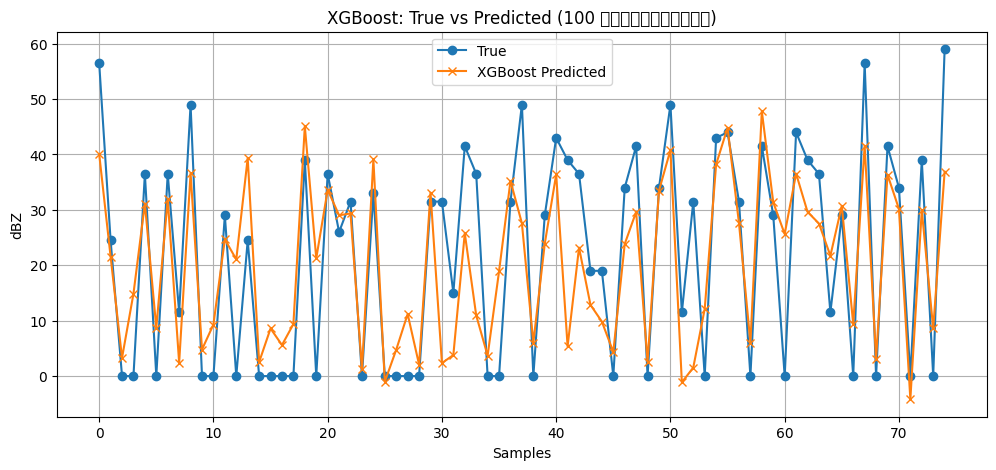

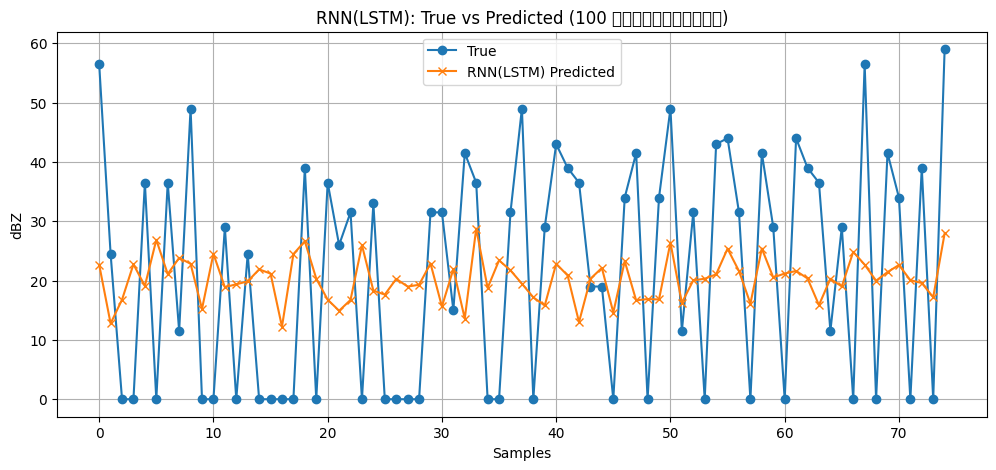

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3648 (\N{THAI CHARACTER SARA E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3611 (\N{THAI CHARACTER PO PLA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3619 (\N{THAI CHARACTER RO RUA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3637 (\N{THAI CHARACTER SARA II}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3618 (\N{THAI CHARACTER YO YAK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)

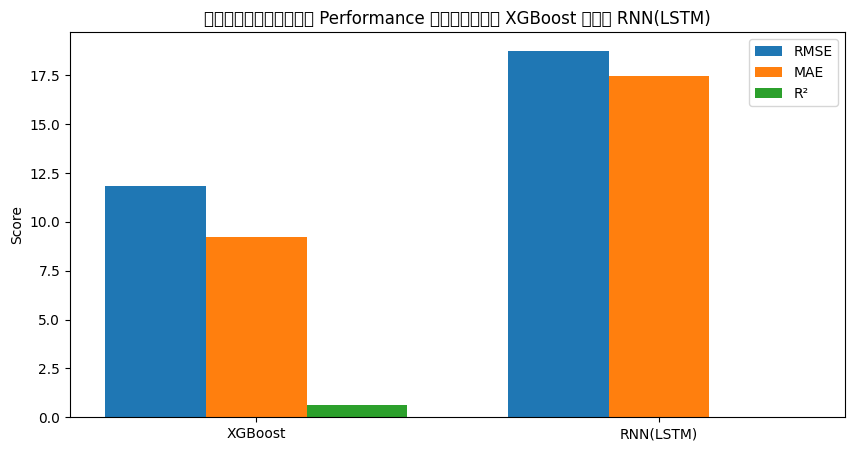

In [37]:
import matplotlib.pyplot as plt

# -------------------- กราฟเปรียบเทียบ XGBoost --------------------
plt.figure(figsize=(12,5))
plt.plot(y_test.values[:100], label="True", marker='o')
plt.plot(y_pred_xgb[:100], label="XGBoost Predicted", marker='x')
plt.title("XGBoost: True vs Predicted (100 ตัวอย่างแรก)")
plt.xlabel("Samples")
plt.ylabel("dBZ")
plt.legend()
plt.grid(True)
plt.show()

# -------------------- กราฟเปรียบเทียบ RNN(LSTM) --------------------
plt.figure(figsize=(12,5))
plt.plot(y_test.values[:100], label="True", marker='o')
plt.plot(y_pred_rnn[:100], label="RNN(LSTM) Predicted", marker='x')
plt.title("RNN(LSTM): True vs Predicted (100 ตัวอย่างแรก)")
plt.xlabel("Samples")
plt.ylabel("dBZ")
plt.legend()
plt.grid(True)
plt.show()

# -------------------- กราฟเปรียบเทียบ Performance --------------------
models = ["XGBoost", "RNN(LSTM)"]
rmse_scores = [rmse_xgb, rmse_rnn]
mae_scores  = [mae_xgb, mae_rnn]
r2_scores   = [r2_xgb, r2_rnn]

plt.figure(figsize=(10,5))
bar_width = 0.25
x = np.arange(len(models))

plt.bar(x, rmse_scores, width=bar_width, label="RMSE")
plt.bar(x+bar_width, mae_scores, width=bar_width, label="MAE")
plt.bar(x+2*bar_width, r2_scores, width=bar_width, label="R²")

plt.xticks(x+bar_width, models)
plt.title("เปรียบเทียบ Performance ระหว่าง XGBoost และ RNN(LSTM)")
plt.ylabel("Score")
plt.legend()
plt.show()